In [11]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing
import timeit
from collections import namedtuple

if "../" not in sys.path:
  sys.path.append("../") 

from lib import plotting
from lib.tile_coding import IHT, tiles
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')

In [2]:
env = gym.make("MountainCar-v0")
env._max_episode_steps = 3000  # Increase upper time limit so we can plot full behaviour

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
class Estimator():
    """
    q-value function approximator. 
    """
    
    def __init__(self, alpha, num_tilings=8, max_size=4096, trace=False):
        
        self.trace = trace
        self.max_size = max_size
        self.num_tilings = num_tilings

        # divide step size equally between tiles
        self.alpha = alpha / num_tilings

        self.iht = IHT(max_size)

        # weight for each tile
        self.weights = np.zeros(max_size)
        if self.trace:
            self.z = np.zeros(max_size)

        # tilecoding software expects position and velocity to be normalized
        self.position_scale = self.num_tilings / (env.observation_space.high[0] - env.observation_space.low[0])
        self.velocity_scale = self.num_tilings / (env.observation_space.high[1] - env.observation_space.low[1])

        
    def featurize_state_action(self, state, action):
        """
        Returns the featurized representation for a state-action pair.
        """
        featurized = tiles(self.iht, self.num_tilings, 
                           [self.position_scale * state[0], 
                            self.velocity_scale * state[1]], 
                           [action])
        return featurized
    
    def predict(self, s, a=None):
        """
        Predicts q-value function using linear FA.
        If action a is given then returns prediction
        for single state-action pair (s, a).
        Otherwise returns predictions for all actions 
        in environment paired with s.   
        """
    
        if a is None:
            features = [self.featurize_state_action(s, i) for i in range(env.action_space.n)]
        else:
            features = [self.featurize_state_action(s, a)]
            
        return [np.sum(self.weights[f]) for f in features]
        
            
    def update(self, s, a, target):
        """
        Updates the estimator parameters for a given state and action towards
        the target, using an eligibility trace if one has been set.
        """
        features = self.featurize_state_action(s, a)
        estimation = np.sum(self.weights[features])   # Linear FA
        delta = (target - estimation)
        
        if self.trace:
            for f in features:
                # self.z[f] += 1
                self.z[f] = 1
            self.weights += self.alpha * delta * self.z
        else:
            for f in features:
                self.weights[f] += self.alpha * delta
            
    def reset_z(self):
        if self.trace:
            self.z = np.zeros(self.max_size)
        else:
            raise ValueError('Estimator has no trace to reset')
        

In [4]:
def make_epsilon_greedy_policy(estimator, epsilon, num_actions):
    """
    Creates an epsilon-greedy policy based on a given q-value approximator and epsilon.    
    """
    def policy_fn(observation):
        action_probs = np.ones(num_actions, dtype=float) * epsilon / num_actions
        q_values = estimator.predict(observation)
        best_action_idx = np.argmax(q_values)
        action_probs[best_action_idx] += (1.0 - epsilon)
        return action_probs
    return policy_fn

In [5]:
def sarsa_lambda(env, estimator, gamma=1.0, epsilon=0.1, 
                 lmbda=0.5):
    
    """
    Sarsa(Lambda) algorithm for finding approximate optimal q-value function via Linear
    FA with eligibility traces.
    """

    episode_return = 0
    episode_steps = 0
    
    # reset the eligibility trace
    estimator.reset_z()

    # Create epsilon-greedy policy
    policy = make_epsilon_greedy_policy(
        estimator, epsilon, env.action_space.n)

    # Reset the environment and pick the first action
    state = env.reset()
    action_probs = policy(state)
    action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

    # Step through episode
    for t in itertools.count():
        # Take a step
        next_state, reward, done, _ = env.step(action)

        if done:
            target = reward
            estimator.update(state, action, target)
            break

        else:
            # Take next step
            next_action_probs = policy(next_state)
            next_action = np.random.choice(
                np.arange(len(next_action_probs)), p=next_action_probs)

            # Estimate q-value at next state-action
            q_new = estimator.predict(
                next_state, next_action)[0]
            target = reward + gamma * q_new
            estimator.update(state, action, target)
            estimator.z *= gamma * lmbda

        state = next_state
        action = next_action
        
        # Update statistics
        episode_return += reward
        episode_steps = t
    
    return episode_return, episode_steps 
    

In [6]:
def sarsa_n(env, estimator, epsilon=0.1, n=1):
    """
    Sarsa(n) algorithm for finding approximate optimal q-value function via Linear
    FA with n-step TD updates.
    """
    episode_return = 0
    episode_steps = 0
    
    # Create epsilon-greedy policy
    policy = make_epsilon_greedy_policy(
        estimator, epsilon, env.action_space.n)

    # Reset the environment and pick the first action
    state = env.reset()
    action_probs = policy(state)
    action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

    # Set up trackers
    states = [state]
    actions = [action]
    rewards = [0.0]
    term = [False]

    # Step through episode
    T = float('inf')
    for t in itertools.count():
        if t < T:           
            # Take a step
            next_state, reward, done, _ = env.step(action)
            states.append(next_state)
            rewards.append(reward)
            term.append(done)

            if done:
                T = t + 1

            else:
                # Take next step
                next_action_probs = policy(next_state)
                next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)

                actions.append(next_action)

        update_time = t + 1 - n
        if update_time >= 0:
            ret = 0
            # accumulate rewards
            for t_ in range(update_time + 1, min(T, update_time + n) + 1):
                ret += rewards[t_]
            # add estimated state action value to the return
            if update_time + n < T:
                q_values_next = estimator.predict(states[update_time + n])
                ret += q_values_next[actions[update_time + n]]
            estimator.update(states[update_time], actions[update_time], ret)
        if update_time == T - 1:
            break

        state = next_state
        action = next_action
        # Update statistics
        episode_return += reward
        episode_steps = t
    
    return episode_return, episode_steps

In [7]:
def run(algorithm, num_episodes, **algorithm_kwargs):
    episode_returns = []
    episode_lengths = []
    for i in range(num_episodes):
        ret, steps = algorithm(**algorithm_kwargs)
        episode_returns.append(ret)
        episode_lengths.append(steps)
        sys.stdout.flush()
        print("\rEpisode {}/{} ({})".format(
            i + 1, num_episodes, ret), end="")
    return episode_returns, episode_lengths

In [15]:
# Note: Because our initial weights are zero our initial q-value estimates for 
# all state-action pairs are optimistic, so don't require epsilin > 0 to explore.
estimator = Estimator(alpha=0.5)
returns, steps = run(sarsa_n, 500, env=env, estimator=estimator, epsilon=0, n=4)
EpisodeStats = namedtuple('Stats', ['episode_rewards', 'episode_lengths'])
stats = EpisodeStats(episode_rewards=returns, episode_lengths=steps)

Episode 500/500 (-106.0)

In [13]:
estimator = Estimator(alpha=0.5, trace=True)
returns, steps = run(sarsa_lambda, 500, env=env, estimator=estimator, gamma=1, epsilon=0, lmbda=0.92)
EpisodeStats = namedtuple('Stats', ['episode_rewards', 'episode_lengths'])
stats = EpisodeStats(episode_rewards=returns, episode_lengths=steps)

Episode 500/500 (-101.0)

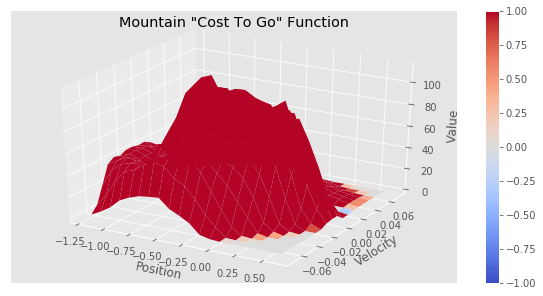

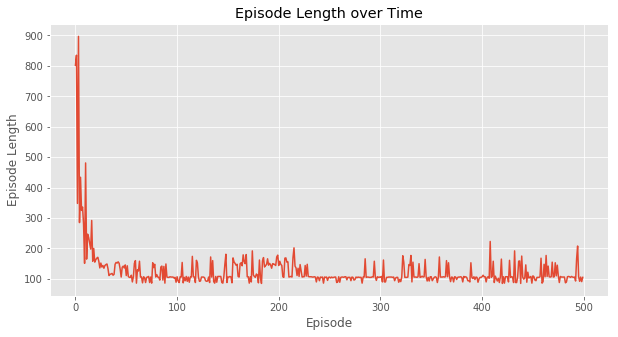

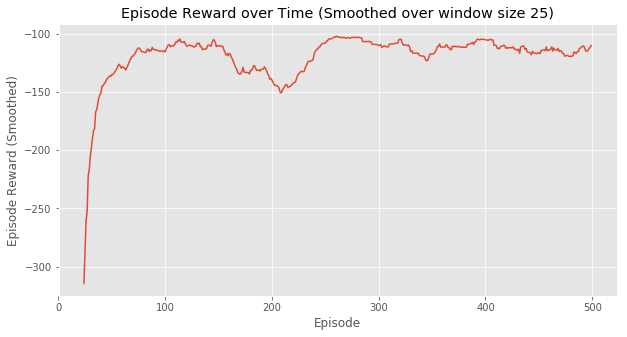

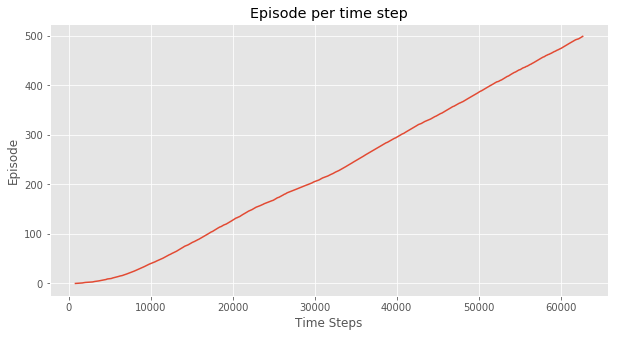

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [16]:
plotting.plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats, smoothing_window=25)

In [6]:
def figure10_4():
    alphas = np.arange(0.1, 1.8, 0.1)
    nSteps = np.power(2, np.arange(0, 5))
    episodes = 100
    runs = 5

    truncateStep = 400
    steps = np.zeros((len(nSteps), len(alphas)))
    for run in range(0, runs):
        for nStepIndex, nStep in zip(range(0, len(nSteps)), nSteps):
            for alphaIndex, alpha in zip(range(0, len(alphas)), alphas):
                #if (nStep == 8 and alpha > 1) or \
                 #       (nStep == 16 and alpha > 0.75):
                    # In these cases it won't converge, so ignore them
                   # steps[nStepIndex, alphaIndex] += truncateStep * episodes
                   # continue
                estimator = Estimator(alpha=alpha)
                for episode in range(0, episodes):
                    print(
                        '\r run: {}, steps: {}, alpha: {}, episode: {}'.format(
                            run, nStep, alpha, episode), end="")
                    stats = q_learning(env, estimator, 1, epsilon=0, n=nStep, log=False)
                    step = stats.episode_lengths[-1]
                    steps[nStepIndex, alphaIndex] += step
    # average over independent runs and episodes
    steps /= runs * episodes
    # truncate high values for better display
    steps[steps > truncateStep] = truncateStep

    plt.figure()
    for i in range(0, len(nSteps)):
        plt.plot(alphas, steps[i, :], label='n = '+str(nSteps[i]))
    plt.xlabel('alpha * number of tilings(8)')
    plt.ylabel('Steps per episode')
    plt.ylim(150, 300)
    plt.legend()

In [77]:
def figure12_10():
    alphas = np.arange(0.1, 1.8, 0.1)
    lambdas = np.array([0, 0.68, 0.84, 0.92, 0.98, 0.99])
    episodes = 100
    runs = 5

    truncateStep = 400
    steps = np.zeros((len(lambdas), len(alphas)))
    for run in range(0, runs):
        for lmbdaIndex, lmbda in zip(range(0, len(lambdas)), lambdas):
            for alphaIndex, alpha in zip(range(0, len(alphas)), alphas):
                #if (nStep == 8 and alpha > 1) or \
                 #       (nStep == 16 and alpha > 0.75):
                    # In these cases it won't converge, so ignore them
                   # steps[nStepIndex, alphaIndex] += truncateStep * episodes
                   # continue
                estimator = Estimator(alpha=alpha, trace=True)
                for episode in range(0, episodes):
                    print(
                        '\r run: {}, lambda: {}, alpha: {}, episode: {}'.format(
                            run, lmbda, alpha, episode), end="")
                    ret, step = sarsa_lambda(env, estimator, gamma=1, epsilon=0, lmbda=lmbda)
                    steps[lmbdaIndex, alphaIndex] += step
    # average over independent runs and episodes
    steps /= runs * episodes
    # truncate high values for better display
    steps[steps > truncateStep] = truncateStep

    plt.figure()
    for i in range(0, len(lambdas)):
        plt.plot(alphas, steps[i, :], label='lmbda = '+str(lambdas[i]))
    plt.xlabel('alpha * number of tilings(8)')
    plt.ylabel('Steps per episode')
    plt.ylim(150, 300)
    plt.legend()

 run: 0, steps: 16, alpha: 1.7000000000000004, episode: 71

/Users/michaeloneill/Documents/RL/venv/lib/python3.5/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/Users/michaeloneill/Documents/RL/venv/lib/python3.5/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars


 run: 3, steps: 16, alpha: 1.6000000000000003, episode: 93

/Users/michaeloneill/Documents/RL/venv/lib/python3.5/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in double_scalars


 run: 4, steps: 16, alpha: 1.7000000000000004, episode: 99

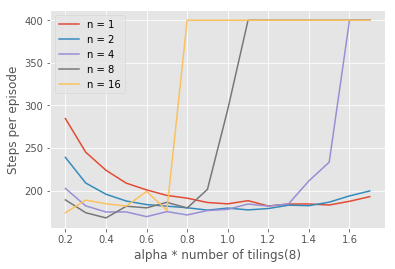

In [7]:
start_time = timeit.default_timer()
figure10_4()
elapsed_time = timeit.default_timer() - start_time

 run: 4, lambda: 0.99, alpha: 1.7000000000000002, episode: 99

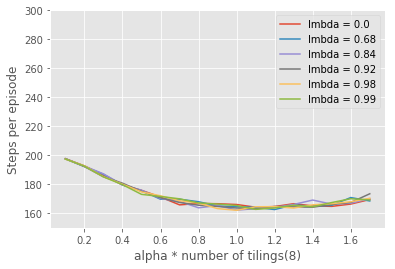

In [78]:
start_time = timeit.default_timer()
figure12_10()
elapsed_time_lmbda = timeit.default_timer() - start_time

## Plot learned policy

In [19]:
import time
env = gym.make("MountainCar-v0")  # Include step limit for validation
epsilon = 0
# The policy we're following
policy = make_epsilon_greedy_policy(
        estimator, epsilon, env.action_space.n)
#for i_episide in range(20):
state = env.reset()
for t in itertools.count():
    time.sleep(0.01)
    action_probs = policy(state)
    action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
    state, _, done, _ = env.step(action)
    env.render()
    if done:
        break

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
